In [1]:
import os
import pandas as pd
import numpy as np
import random

# get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')



In [2]:

df_phish = pd.read_csv('PhishingWebsitesData.csv').astype('category')
print("Data has",len(df_phish),"rows and", len(df_phish.columns),"columns.")
if df_phish.isnull().values.any():
    print("Warning: Missing Data")
#df_phish.head()
#df_phish.describe(include='all')


col_1hot = ['URL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
df_1hot = df_phish[col_1hot]
df_1hot = pd.get_dummies(df_1hot)
df_others = df_phish.drop(col_1hot,axis=1)
df_phish = pd.concat([df_1hot,df_others],axis=1)
df_phish = df_phish.replace(-1,0).astype('category')
column_order = list(df_phish)
column_order.insert(0, column_order.pop(column_order.index('Result')))
df_phish = df_phish.loc[:, column_order]  #move the target variable 'Result' to the front

Data has 11055 rows and 31 columns.


In [109]:
df_mobile = pd.read_csv('mobiledata.csv').astype('category')
print("Data has",len(df_mobile),"rows and", len(df_mobile.columns),"columns.")
if df_mobile.isnull().values.any():
    print("Warning: Missing Data")
#df_phish.head()
#df_phish.describe(include='all')


col_1hot = ['n_cores']
df_1hot = df_mobile[col_1hot]
df_1hot = pd.get_dummies(df_1hot)
df_others = df_mobile.drop(col_1hot,axis=1)
df_mobile = pd.concat([df_1hot,df_others],axis=1)
df_mobile = df_mobile.replace(-1,0).astype('category')
column_order = list(df_mobile)
column_order.insert(0, column_order.pop(column_order.index('price_range')))
df_mobile = df_mobile.loc[:, column_order]  #move the target variable 'Result' to the front

Data has 2000 rows and 21 columns.


In [3]:

df_star = pd.read_csv('pulsar_stars.csv').astype('category')
print("Data has",len(df_star),"rows and", len(df_star.columns),"columns.")
if df_star.isnull().values.any():
    print("Warning: Missing Data")
#df_phish.head()
#df_phish.describe(include='all')


# col_1hot = ['URL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
# df_1hot = df_phish[:]
# df_1hot = pd.get_dummies(df_1hot)
# df_others = df_phish.drop(col_1hot,axis=1)
# df_star = pd.concat([df_1hot,df_others],axis=1)
# df_star = df_star.replace(-1,0).astype('category')
column_order = list(df_star)
column_order.insert(0, column_order.pop(column_order.index('target_class')))
df_star = df_star.loc[:, column_order]  #move the target variable 'Result' to the front

Data has 17898 rows and 9 columns.


In [4]:
rawData = pd.read_csv('pulsar_stars.csv')
features = list(rawData)[:-1]
target = rawData.iloc[:,-1]
data = rawData.loc[:, rawData.columns != "target_class"]

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 12

In [6]:
def import_data():

    X1 = np.array(df_phish.values[:,1:-1],dtype='int64')
    Y1 = np.array(df_phish.values[:,0],dtype='int64')
    X2 = np.array(df_star.values[:,1:-1],dtype='int64')
    Y2 = np.array(df_star.values[:,0],dtype='int64')
#     X2 = np.array(data,dtype='int64')
#     Y2 = np.array(target,dtype='int64')
    return X1, Y1, X2, Y2

In [7]:
def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)


    
    return train_sizes, train_mean, fit_mean, pred_mean

In [8]:
def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")

#     plt.grid()
#     plt.savefig('ex1_' + file_name + 'curve.png')
#     plt.tight_layout()

    plt.show()

In [9]:
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")

#     plt.grid()
#     plt.savefig('ex1_' + file_name + 'curve.png')
#     plt.tight_layout()

    plt.show()

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(len(classes)), range(len(classes))):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

#     plt.grid()
#     plt.savefig('ex1_' + file_name + 'curve.png')
#     plt.tight_layout()

In [11]:
# def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
#     start_time = timeit.default_timer()
#     clf.fit(X_train, y_train)
#     end_time = timeit.default_timer()
#     training_time = end_time - start_time
    
#     start_time = timeit.default_timer()    
#     y_pred = clf.predict(X_test)
#     end_time = timeit.default_timer()
#     pred_time = end_time - start_time
    
#     auc = roc_auc_score(y_test, y_pred)
#     f1 = f1_score(y_test,y_pred)
#     accuracy = accuracy_score(y_test,y_pred)
#     precision = precision_score(y_test,y_pred)
#     recall = recall_score(y_test,y_pred)
#     cm = confusion_matrix(y_test,y_pred)

#     print("Model Evaluation Metrics Using Untouched Test Dataset")
#     print("*****************************************************")
#     print("Model Training Time (s):   "+"{:.5f}".format(training_time))
#     print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
#     print("F1 Score:  "+"{:.2f}".format(f1))
#     print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
#     print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
#     print("*****************************************************")
#     plt.figure()
#     plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')


# #     plt.grid()
# #     plt.savefig('ex1_' + file_name + 'curve.png')
# #     plt.tight_layout()

#     plt.show()
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
#     auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
#     print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()
    plt.savefig('img/final_evaluation.png')

In [12]:
def cluster_predictions(Y,clusterLabels):
#     print(Y.shape)
#     print(clusterLabels.shape)
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)    
    return pred

In [13]:
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]


In [14]:
from sklearn.neural_network import MLPClassifier

def hyperNN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    hlist = np.linspace(1,150,30).astype('int')
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic', 
                                learning_rate_init=0.05, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(accuracy_score(y_test, y_pred_test))
            f1_train.append(accuracy_score(y_train, y_pred_train))
      
    plt.plot(hlist, f1_train, 'o-', color = 'b', label='Train Accuracy')
    plt.plot(hlist, f1_test, 'o-', color='r', label='Test Accuracy')
    plt.ylabel('Model Accuracy')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def NNGridSearchCV(X_train, y_train):
    #parameters to search:
    #number of hidden units
    #learning_rate
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    param_grid = {'hidden_layer_sizes': h_units}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',learning_rate_init=0.05,random_state=100),
                       param_grid=param_grid, cv=10)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes']

# K-Means

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt


np.random.seed(0)

def run_kmeans(X,y,title):

    kclusters = list(np.arange(2,50,2))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []

    for k in kclusters:
        start_time = timeit.default_timer()
        km = KMeans(n_clusters=k, n_init=10,random_state=100,n_jobs=-1).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        sil_scores.append(sil_score(X, km.labels_))
        y_mode_vote = cluster_predictions(y,km.labels_)
#         f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, km.labels_))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('K and Silhouette Score for KMeans: '+ title)
    plt.show()
    plt.savefig('img/kmeans_sil_score' + title + '.png')

   
    # plot homogeneity scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, homo_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Homogeneity Score')
    plt.title('K and Homogeneity Scores KMeans: '+ title)
    plt.show()
    plt.savefig('img/kmeans_homo_score' + title + '.png')

def evaluate_kmeans(km, X, y):
    start_time = timeit.default_timer()
    km.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    y_mode_vote = cluster_predictions(y,km.labels_)
#     auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote, average='macro')
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote, average='macro')
    recall = recall_score(y, y_mode_vote, average='macro')
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))
    print("F1 Score:  "+"{:.2f}".format(f1))
#     print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    cl = range(max(y)+1)
    cl = [str(ele) for ele in cl]
#     print(cl)
    plot_confusion_matrix(cm, classes=cl, title='Confusion Matrix')
#     plt.show()
    plt.savefig('img/kmeans_evaluation' + str(km.n_clusters) + '.png')

In [20]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
def vis(X, y, nameappendix, k):
    
    scaler = MinMaxScaler(feature_range=[0,100])
    scaler.fit(X)
    X = pd.DataFrame(scaler.transform(X))
    
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 6)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    print("Num of clusters: ", k)
    clusters = KMeans(n_clusters = k, random_state = 10).fit(X)
    labels = clusters.labels_
    print("NMI score: %.5f" % normalized_mutual_info_score(y, labels))

    silhouette_avg = sil_score(X, labels)
    print("Silhouette score: ", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, labels)


    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

#             color = plt.spectral(float(i) / numOfCluster)
        color = plt.get_cmap('Spectral')(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Coefficients for Clusters.")
    ax1.set_xlabel("Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Labels")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
#         colors = plt.spectral(labels.astype(float) / numOfCluster)
    colors = plt.get_cmap('Spectral')(labels.astype(float) / k)
#     print(X.values[:, 10])
#         colors = ["b","g","r","c","m","y","k"]
    ax2.scatter(X.values[:, 3], X.values[:,5], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusters.cluster_centers_

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 3], centers[:, 5], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[3], c[5], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Clustering Visualization")
    ax2.set_xlabel("1st feature: Pressure X4")
    ax2.set_ylabel("2nd feature: Pressure X5")

    plt.suptitle("Analysis for KMeans for " + str(k) + " Clusters", fontsize=14, fontweight='bold')
#     plt.savefig('img/kmeans_vis' + str(k) + '.png')
    plt.show()

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.94
No. Iterations to Converge: 29
F1 Score:  0.83
Precision: 0.88     Recall:    0.82
*****************************************************


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.311880
For n_clusters = 9 The average silhouette_score is : 0.07868776722987854


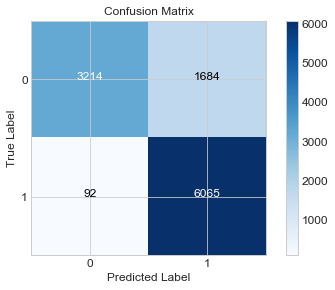

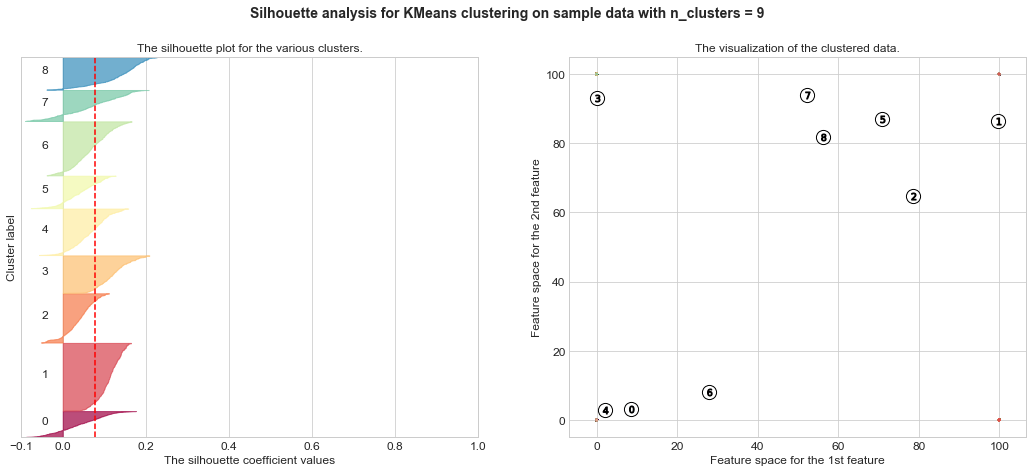

In [152]:
phishX,phishY,bankX,bankY = import_data()
#run_kmeans(phishX,phishY,'Phishing Data')
km = KMeans(n_clusters=9,n_init=10,random_state=100,n_jobs=-1)
evaluate_kmeans(km,phishX,phishY)
vis(phishX, phishY, 'phish_data', 9)

# df = pd.DataFrame(km.cluster_centers_)
# df.to_csv("Phishing kMeans Cluster Centers.csv")

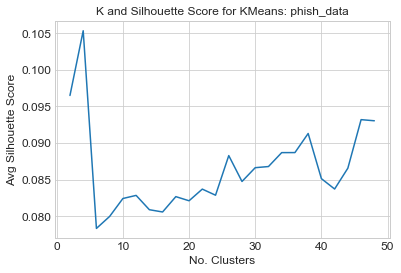

<Figure size 432x288 with 0 Axes>

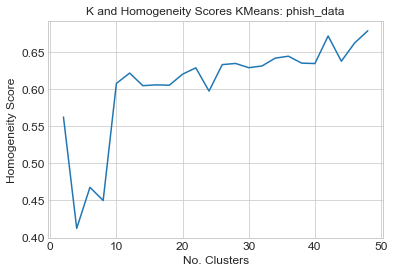

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.23
No. Iterations to Converge: 14
F1 Score:  0.91
Precision: 0.91     Recall:    0.91
*****************************************************
Num of clusters:  2


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.56437
Silhouette score:  0.0965009778747322
[  0. 100. 100. ... 100.   0.   0.]


<Figure size 432x288 with 0 Axes>

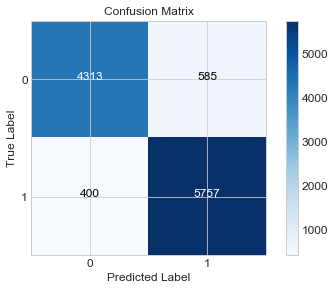

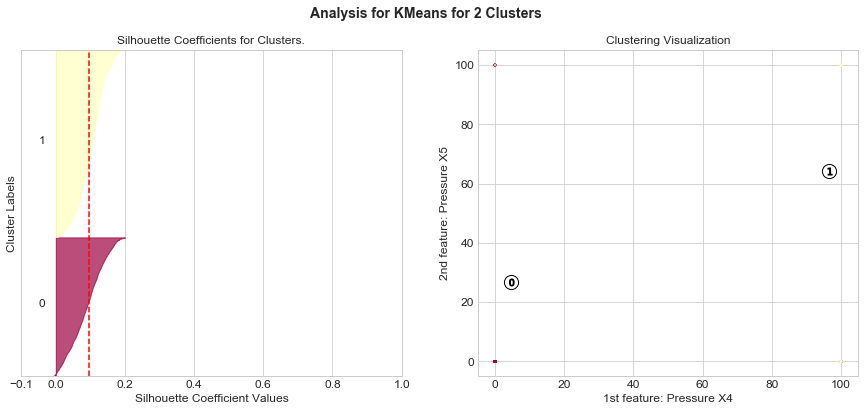

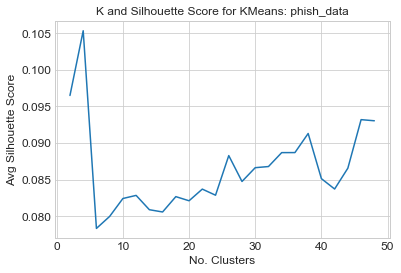

<Figure size 432x288 with 0 Axes>

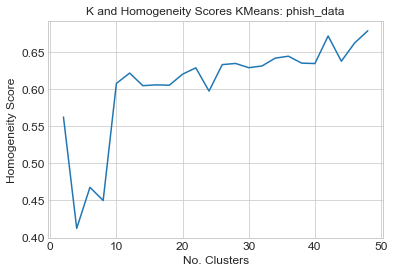

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.38
No. Iterations to Converge: 19
F1 Score:  0.82
Precision: 0.85     Recall:    0.82
*****************************************************
Num of clusters:  4


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.30698
Silhouette score:  0.10551352293031184
[  0. 100. 100. ... 100.   0.   0.]


<Figure size 432x288 with 0 Axes>

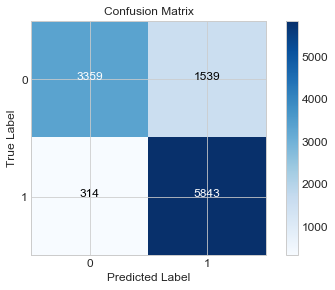

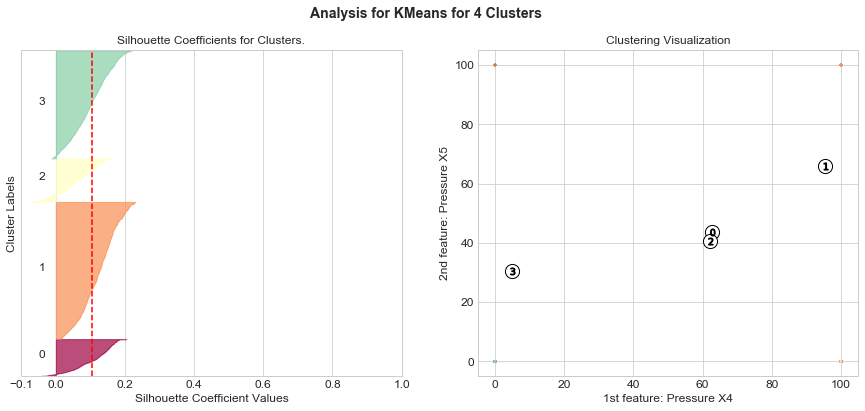

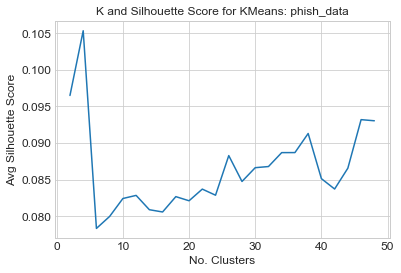

<Figure size 432x288 with 0 Axes>

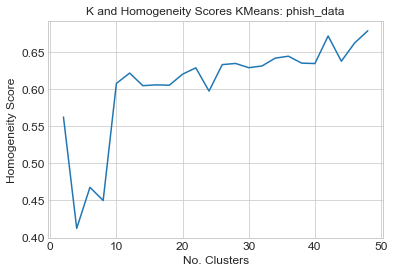

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.50
No. Iterations to Converge: 12
F1 Score:  0.82
Precision: 0.82     Recall:    0.81
*****************************************************
Num of clusters:  6


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.29143
Silhouette score:  0.0784035323310035
[  0. 100. 100. ... 100.   0.   0.]


<Figure size 432x288 with 0 Axes>

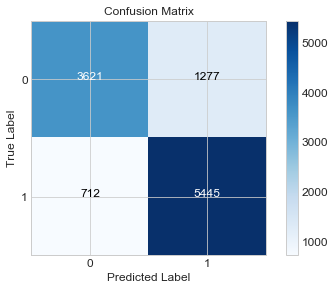

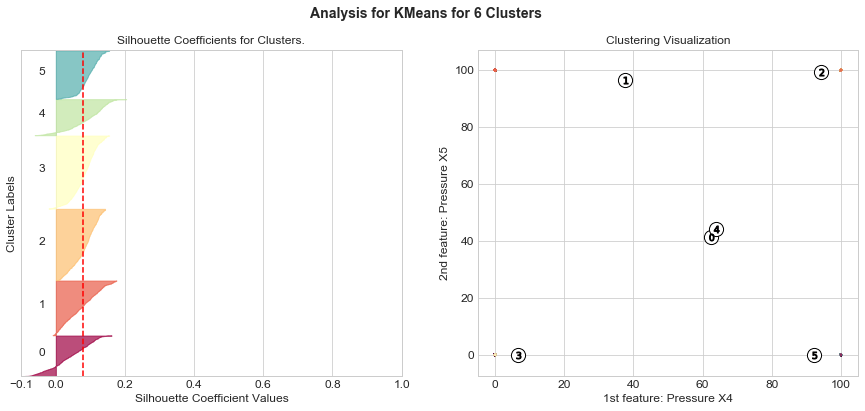

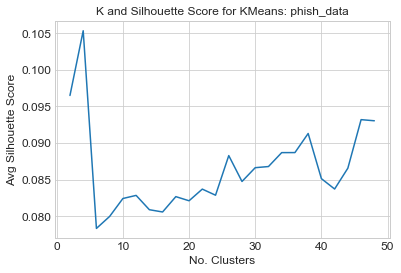

<Figure size 432x288 with 0 Axes>

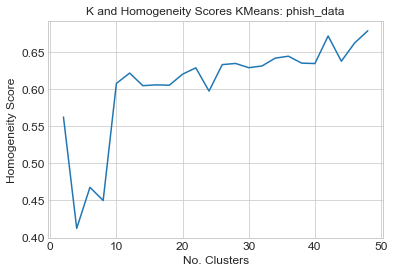

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.57
No. Iterations to Converge: 27
F1 Score:  0.79
Precision: 0.87     Recall:    0.79
*****************************************************
Num of clusters:  8


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.30344
Silhouette score:  0.09010410725589924
[  0. 100. 100. ... 100.   0.   0.]


<Figure size 432x288 with 0 Axes>

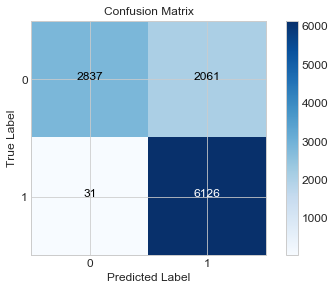

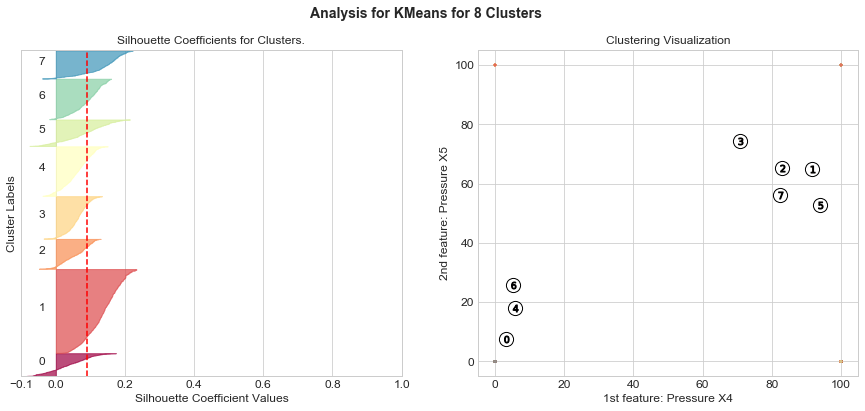

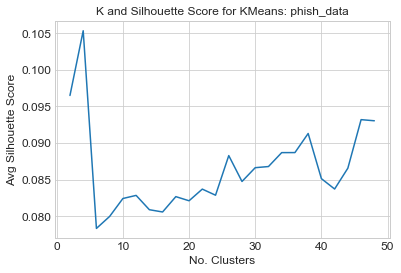

<Figure size 432x288 with 0 Axes>

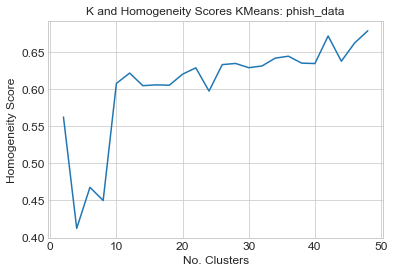

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.73
No. Iterations to Converge: 28
F1 Score:  0.90
Precision: 0.91     Recall:    0.90
*****************************************************
Num of clusters:  10


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.34466
Silhouette score:  0.07889048027484909
[  0. 100. 100. ... 100.   0.   0.]


<Figure size 432x288 with 0 Axes>

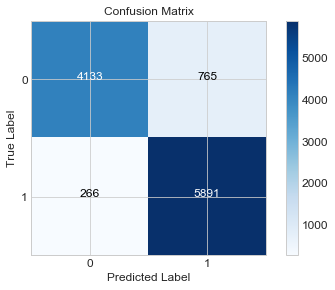

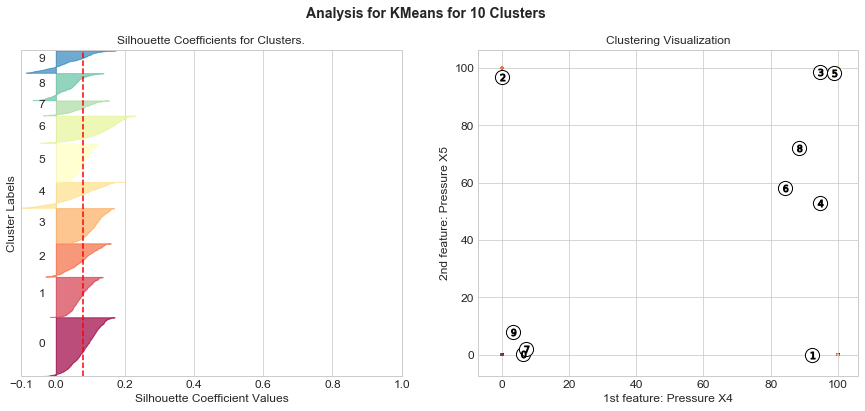

In [229]:
krange = [2,4,6,8,10]
for k in krange:
    run_kmeans(phishX, phishY, 'phish_data')
    km = KMeans(n_clusters=k,n_init=10,random_state=100,n_jobs=-1)
    evaluate_kmeans(km,phishX,phishY)
    vis(phishX, phishY, 'phish_data', k)
#     df = pd.DataFrame(km.cluster_centers_)

In [19]:
bankX[:,6]

array([ 7, 10,  7, ...,  2, 10, -1])

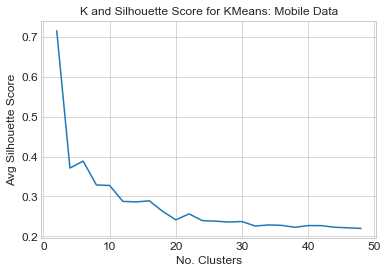

<Figure size 432x288 with 0 Axes>

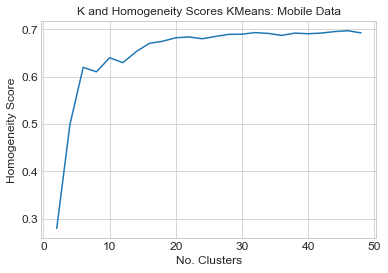

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.27
No. Iterations to Converge: 13
F1 Score:  0.84
Precision: 0.96     Recall:    0.78
*****************************************************
Num of clusters:  4


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.29826
Silhouette score:  0.31474530444911947


<Figure size 432x288 with 0 Axes>

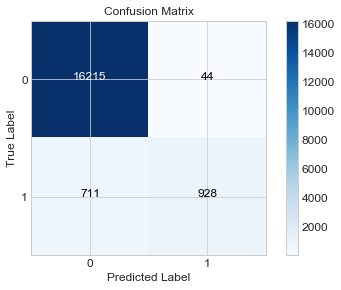

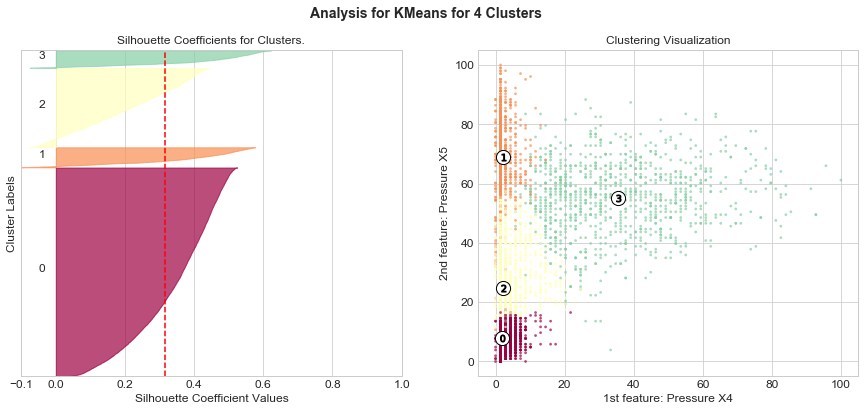

In [21]:
phishX,phishY,bankX,bankY = import_data()
run_kmeans(bankX,bankY,'Mobile Data')
km = KMeans(n_clusters=4,n_init=10,random_state=100,n_jobs=-1)
evaluate_kmeans(km,bankX,bankY)
df = pd.DataFrame(km.cluster_centers_)
vis(bankX,bankY, 'Mobile_data', 4)
# df.to_csv("Banking kMeans Cluster Centers.csv")

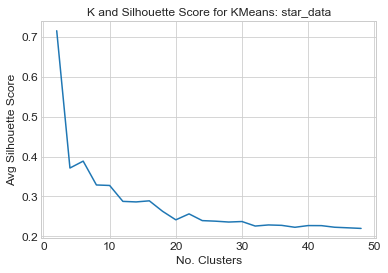

<Figure size 432x288 with 0 Axes>

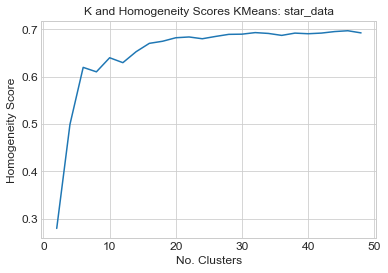

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.11
No. Iterations to Converge: 6
F1 Score:  0.77
Precision: 0.76     Recall:    0.78
*****************************************************
Num of clusters:  2


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.33810
Silhouette score:  0.6509327295295438


<Figure size 432x288 with 0 Axes>

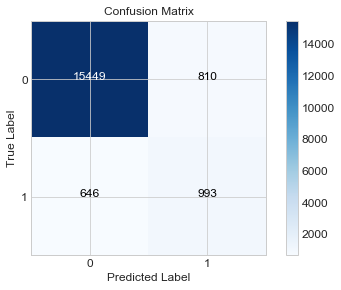

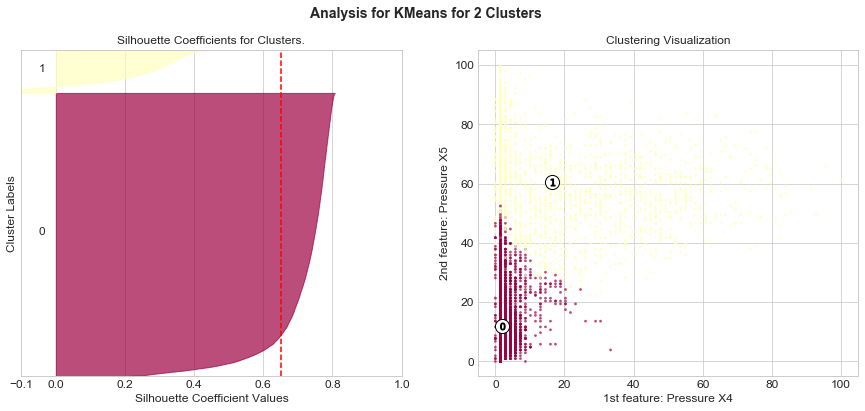

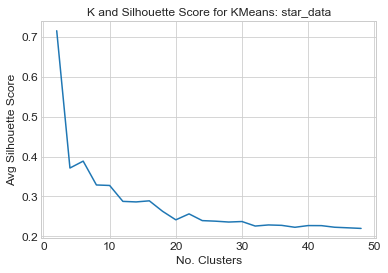

<Figure size 432x288 with 0 Axes>

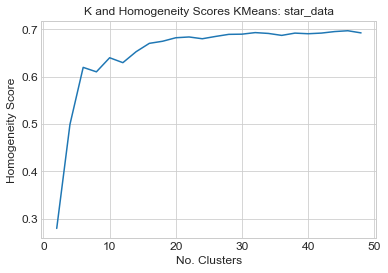

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.19
No. Iterations to Converge: 17
F1 Score:  0.87
Precision: 0.95     Recall:    0.82
*****************************************************
Num of clusters:  3


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.40965
Silhouette score:  0.6287785724723872


<Figure size 432x288 with 0 Axes>

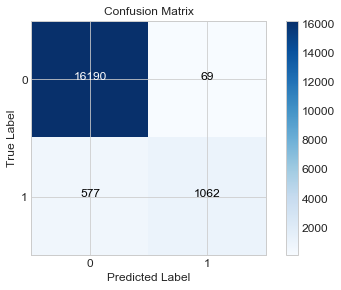

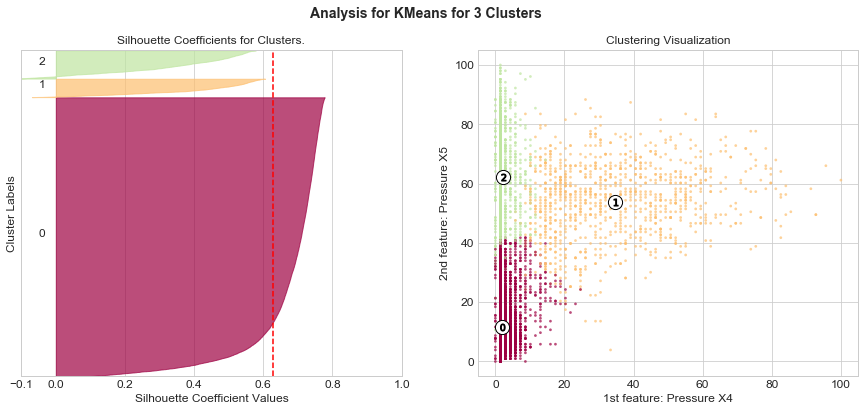

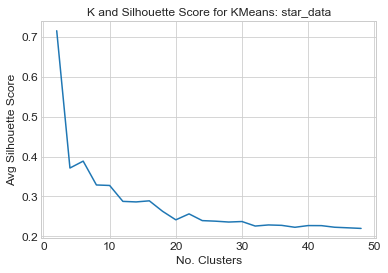

<Figure size 432x288 with 0 Axes>

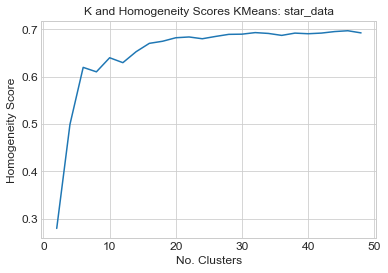

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.30
No. Iterations to Converge: 13
F1 Score:  0.84
Precision: 0.96     Recall:    0.78
*****************************************************
Num of clusters:  4


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.29826
Silhouette score:  0.31474530444911947


<Figure size 432x288 with 0 Axes>

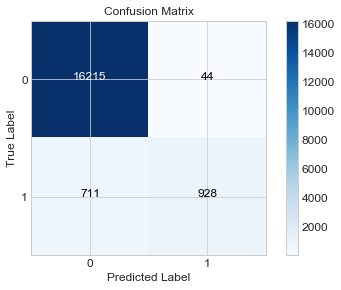

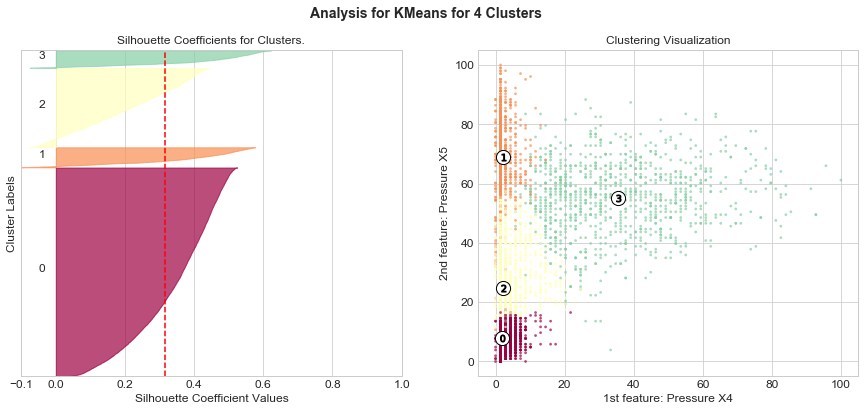

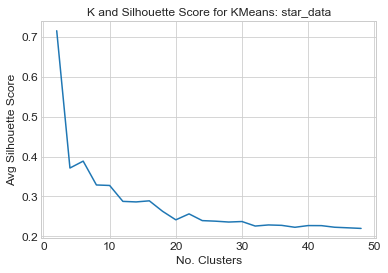

<Figure size 432x288 with 0 Axes>

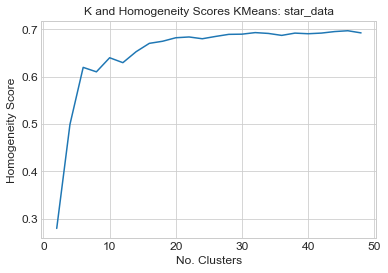

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.48
No. Iterations to Converge: 16
F1 Score:  0.89
Precision: 0.96     Recall:    0.84
*****************************************************
Num of clusters:  8


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.26400
Silhouette score:  0.2767510806003417


<Figure size 432x288 with 0 Axes>

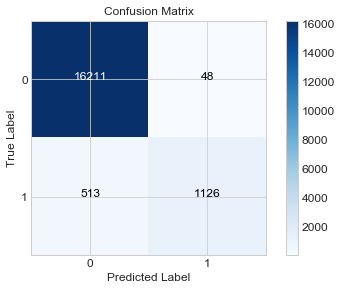

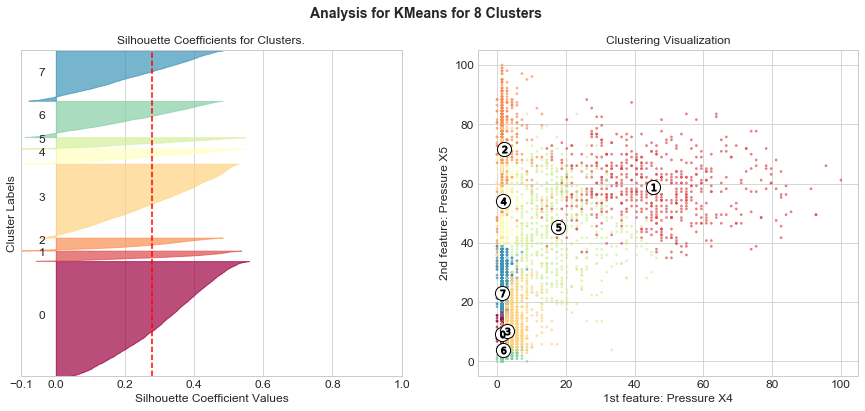

In [23]:
phishX,phishY,bankX,bankY = import_data()
krange = [2,3,4,8]
for k in krange:
    run_kmeans(bankX,bankY, 'star_data')
    km = KMeans(n_clusters=k,n_init=10,random_state=100,n_jobs=-1)
    evaluate_kmeans(km,bankX,bankY)
    vis(bankX,bankY, 'star_data', k)

# Expectation Maximization

In [26]:
from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def run_EM(X,y,title):

    #kdist =  [2,3,4,53
    #kdist = list(range(2,51))
    kdist = list(np.arange(2,150,5))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; aic_scores = []; bic_scores = []
    
    for k in kdist:
        start_time = timeit.default_timer()
        em = EM(n_components=k,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        labels = em.predict(X)
        sil_scores.append(sil_score(X, labels))
        y_mode_vote = cluster_predictions(y,labels)
#         f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, labels))
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for EM: '+ title)
    plt.show()
   
    # plot homogeneity scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, homo_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Homogeneity Score')
    plt.title('Homogeneity Scores EM: '+ title)
    plt.show()

    # plot f1 scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, f1_scores)
#     plt.grid(True)
#     plt.xlabel('No. Distributions')
#     plt.ylabel('F1 Score')
#     plt.title('F1 Scores EM: '+ title)
#     plt.show()

    # plot model AIC and BIC
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, aic_scores, label='AIC')
    ax.plot(kdist, bic_scores,label='BIC')
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity: '+ title)
    plt.legend(loc="best")
    plt.show()
    
def evaluate_EM(em, X, y):
    start_time = timeit.default_timer()
    em.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    labels = em.predict(X)
    y_mode_vote = cluster_predictions(y,labels)
#     auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote, average='macro')
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote, average='macro')
    recall = recall_score(y, y_mode_vote, average='macro')
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(em.n_iter_))
    print("Log-likelihood Lower Bound: {:.2f}".format(em.lower_bound_))
    print("F1 Score:  "+"{:.2f}".format(f1))
#     print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    cl = range(max(y)+1)
    cl = [str(ele) for ele in cl]
    plot_confusion_matrix(cm, classes=cl, title='Confusion Matrix')
    plt.show()
    
def myem(X, y, nameappendix, krange):
    for n_clusters in krange:
        fig = plt.gcf()
        # fig.set_size_inches(7, 7)
        ax = fig.add_subplot(111)

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = EM(n_components=n_clusters, random_state=10).fit(X)
        labels = clusterer.predict(X)
        print("NMI score: %.6f" % normalized_mutual_info_score(y, labels))

        # 2nd Plot showing the actual clusters formed
#         colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        colors = plt.get_cmap('Spectral')(labels.astype(float) / n_clusters)
        plt.scatter(X[:, 3], X[:, 5], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.means_

        # Draw white circles at cluster centers
        plt.scatter(centers[:, 3], centers[:, 5], marker='o', c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax.scatter( c[3], c[5], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax.set_title("Clustering Visualization")
        ax.set_xlabel("1st feature: Pressure X4")
        ax.set_ylabel("2nd feature: Pressure X5")

        plt.suptitle("Analysis for EM Clustering for " + str(n_clusters) + " Clusters", fontsize=14, fontweight='bold')
        plt.savefig('img/em' + nameappendix + '.png')
        plt.show()

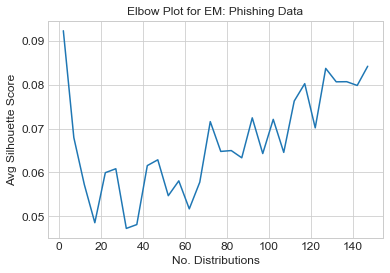

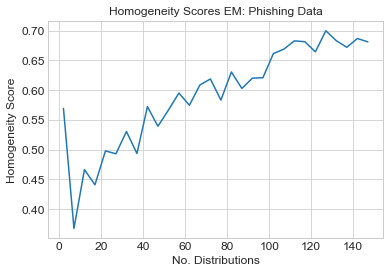

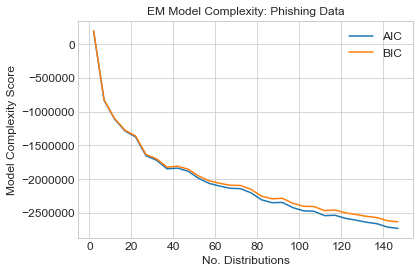

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.54
No. Iterations to Converge: 14
Log-likelihood Lower Bound: 66.57
F1 Score:  0.83
Precision: 0.83     Recall:    0.83
*****************************************************


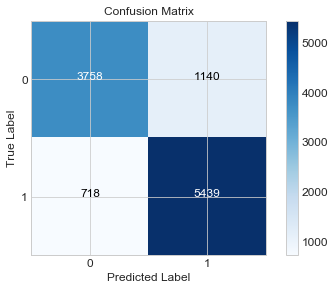

/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.569033


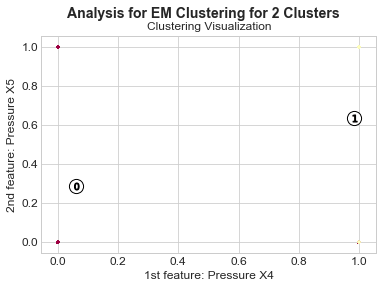

/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.291456


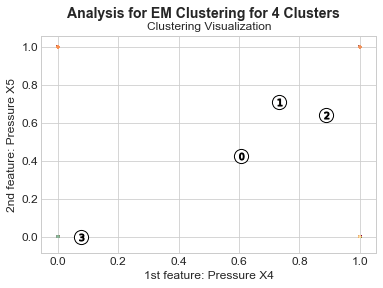

/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.235764


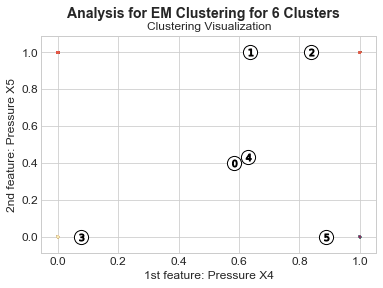

/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.205948


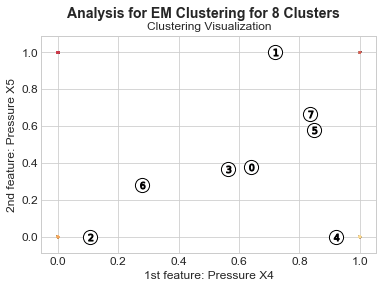

/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.162674


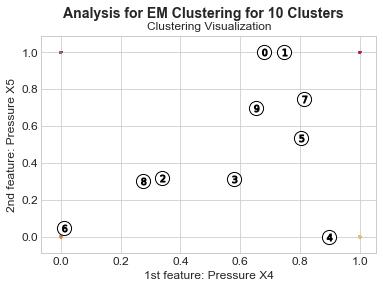

In [180]:
phishX,phishY,bankX,bankY = import_data()
run_EM(phishX,phishY,'Phishing Data')
em = EM(n_components=24,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,phishX,phishY)
df = pd.DataFrame(em.means_)
df.to_csv("Phishing EM Component Means.csv")
myem(phishX, phishY, 'phish', [2,4,6,8,10])

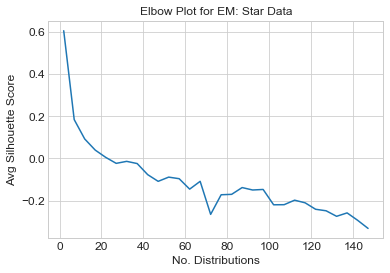

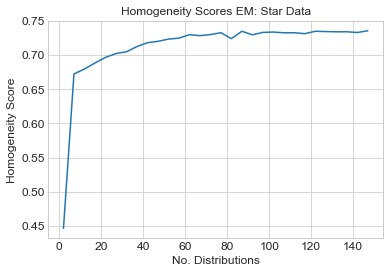

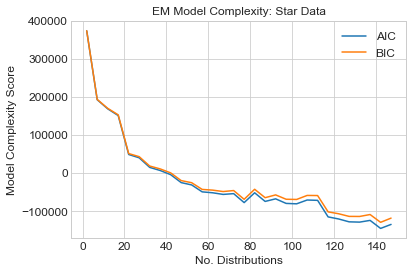

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.10
No. Iterations to Converge: 9
Log-likelihood Lower Bound: -9.29
F1 Score:  0.92
Precision: 0.95     Recall:    0.90
*****************************************************


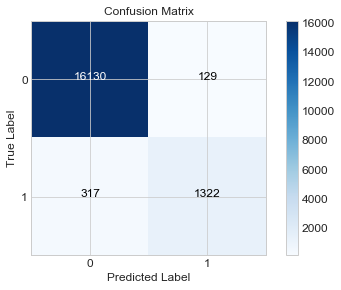

/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.359545


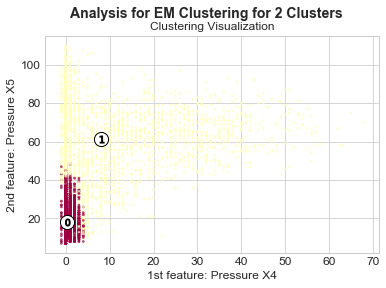

/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.268092


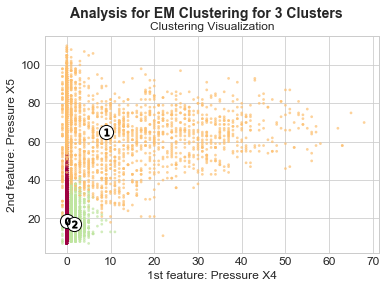

/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.380795


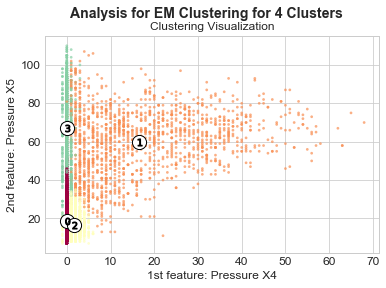

/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI score: 0.343914


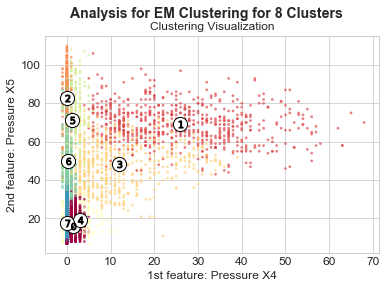

In [27]:
phishX,phishY,bankX,bankY = import_data()
X_train, X_test, y_train, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.25)
run_EM(X_train,y_train,'Star Data')
em = EM(n_components=4,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,bankX,bankY)
df = pd.DataFrame(em.means_)
df.to_csv("Star EM Component Means.csv")
myem(bankX, bankY, 'star', [2,3,4,8])

# Dimensionality Reduction

In [1]:
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict

def run_PCA(X,y,title):
    
    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("PCA Explained Variance and Eigenvalues: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_ICA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    ica = ICA(random_state=5)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

def run_RCA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in product(range(5),dims):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_RFC(X,y,df_original):
    rfc = RFC(n_estimators=500,min_samples_leaf=round(len(X)*.01),random_state=5,n_jobs=-1)
    imp = rfc.fit(X,y).feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=df_original.columns[2::])
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.9]
    top_cols = imp.index.tolist()
    return imp, top_cols

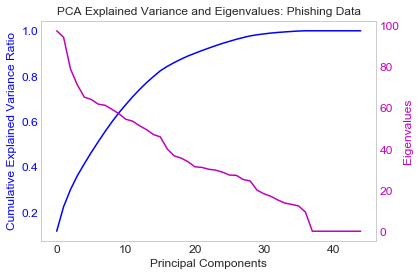

/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


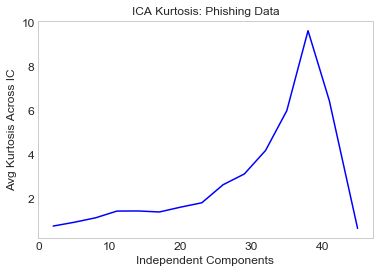

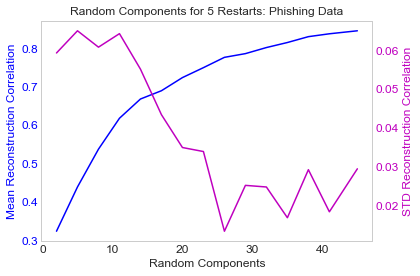

In [183]:
phishX,phishY,bankX,bankY = import_data()
run_PCA(phishX,phishY,"Phishing Data")
run_ICA(phishX,phishY,"Phishing Data")
run_RCA(phishX,phishY,"Phishing Data")
imp_phish, topcols_phish = run_RFC(phishX,phishY,df_phish)

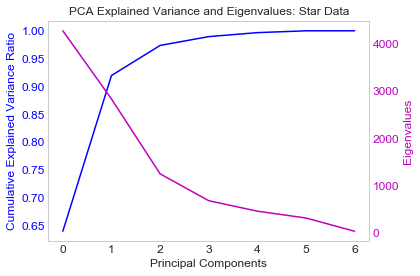

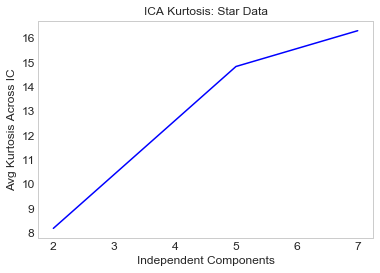

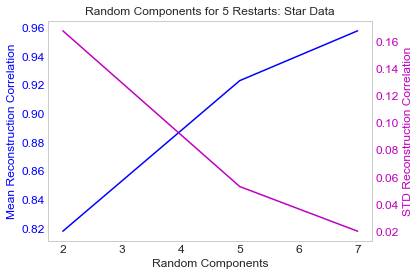

In [43]:
phishX,phishY,bankX,bankY = import_data()
X_train, X_test, y_train, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.2)
run_PCA(X_train,bankY,"Star Data")
run_ICA(X_train,bankY,"Star Data")
run_RCA(X_train,bankY,"Star Data")
imp_bank, topcols_bank = run_RFC(X_train,y_train,df_star)

In [186]:
topcols_bank

['sc_h',
 'blue',
 'ram',
 'px_width',
 'pc',
 'm_dep',
 'three_g',
 'sc_w',
 'px_height']

In [187]:
phishX,phishY,bankX,bankY = import_data()
imp_phish, topcols_phish = run_RFC(phishX,phishY,df_phish)
pca_phish = PCA(n_components=25,random_state=5).fit_transform(phishX)
ica_phish = ICA(n_components=38,random_state=5).fit_transform(phishX)
rca_phish = ICA(n_components=29,random_state=5).fit_transform(phishX)
rfc_phish = df_phish[topcols_phish]
rfc_phish = np.array(rfc_phish.values,dtype='int64')

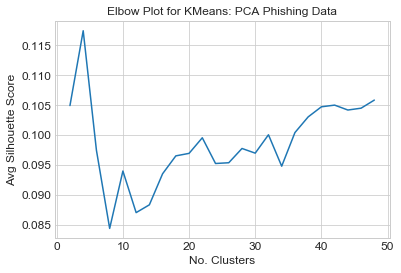

<Figure size 432x288 with 0 Axes>

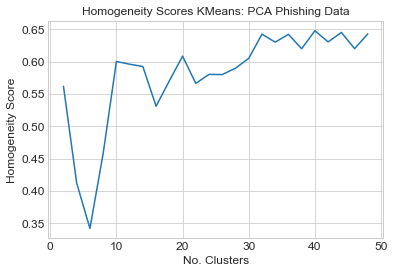

<Figure size 432x288 with 0 Axes>

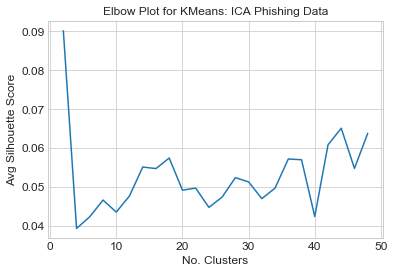

<Figure size 432x288 with 0 Axes>

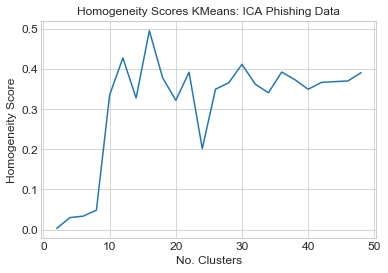

<Figure size 432x288 with 0 Axes>

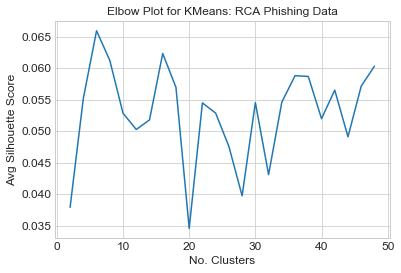

<Figure size 432x288 with 0 Axes>

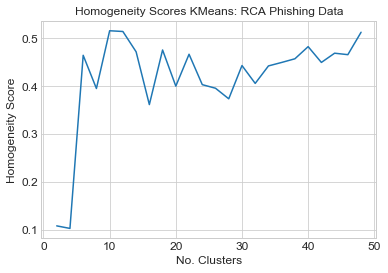

<Figure size 432x288 with 0 Axes>

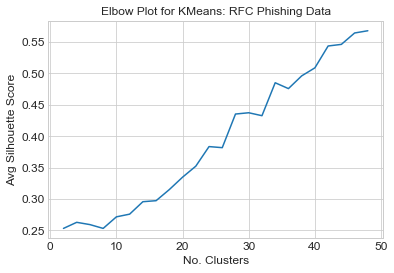

<Figure size 432x288 with 0 Axes>

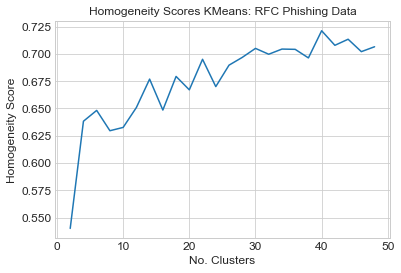

<Figure size 432x288 with 0 Axes>

In [188]:
run_kmeans(pca_phish,phishY,'PCA Phishing Data')
run_kmeans(ica_phish,phishY,'ICA Phishing Data')
run_kmeans(rca_phish,phishY,'RCA Phishing Data')
run_kmeans(rfc_phish,phishY,'RFC Phishing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.90
No. Iterations to Converge: 25
F1 Score:  0.89
Precision: 0.89     Recall:    0.89
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.80
No. Iterations to Converge: 27
F1 Score:  0.81
Precision: 0.82     Recall:    0.80
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.62
No. Iterations to Converge: 19
F1 Score:  0.83
Precision: 0.84     Recall:    0.83
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.24
No. Iterations to Converge: 7
F1 Score:  0.91
Pre

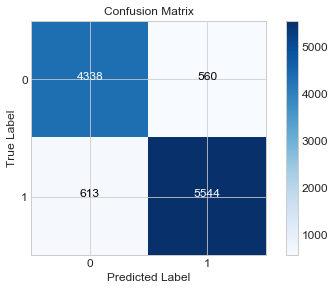

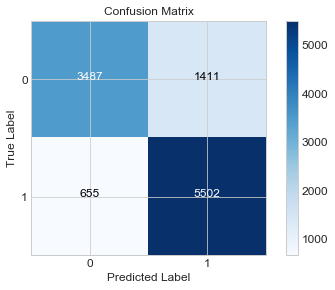

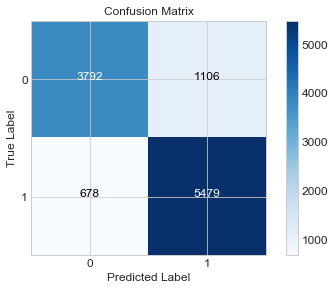

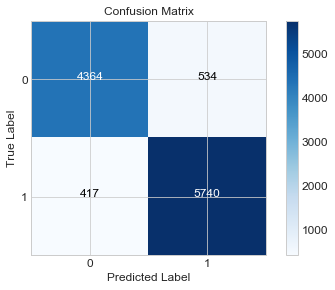

In [193]:
evaluate_kmeans(KMeans(n_clusters=14,n_init=10,random_state=100,n_jobs=-1),pca_phish,phishY)
evaluate_kmeans(KMeans(n_clusters=12,n_init=10,random_state=100,n_jobs=-1),ica_phish,phishY)
evaluate_kmeans(KMeans(n_clusters=10,n_init=10,random_state=100,n_jobs=-1),rca_phish,phishY)
evaluate_kmeans(KMeans(n_clusters=14,n_init=10,random_state=100,n_jobs=-1),rfc_phish,phishY)


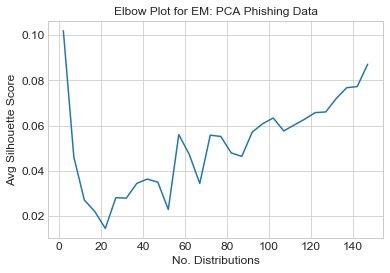

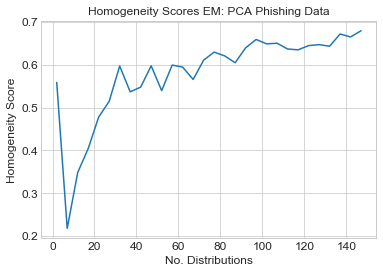

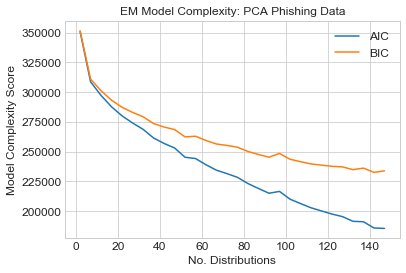

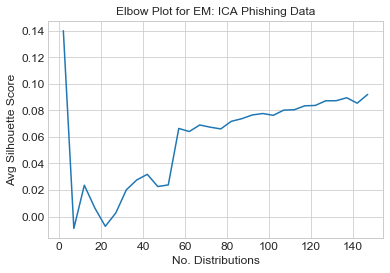

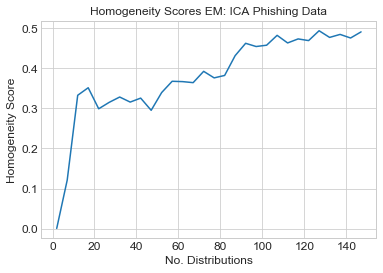

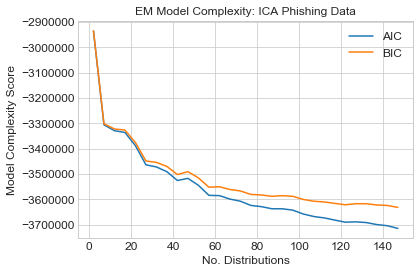

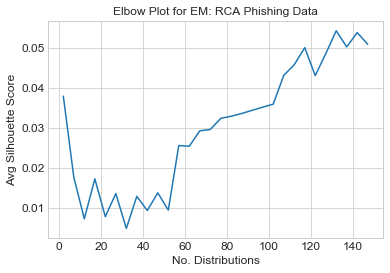

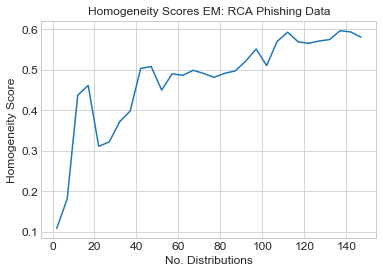

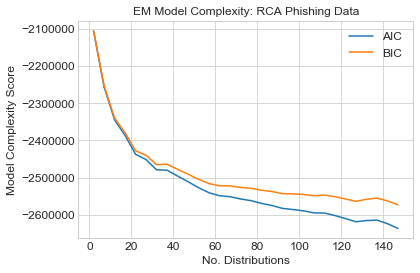

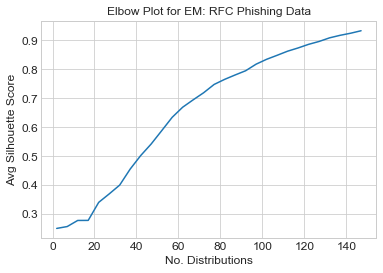

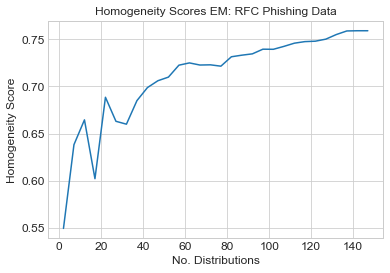

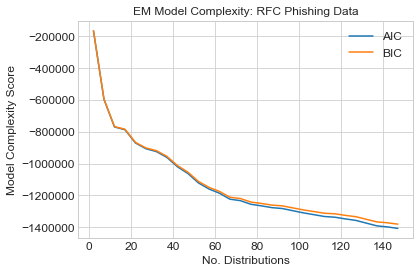

In [194]:
run_EM(pca_phish,phishY,'PCA Phishing Data')
run_EM(ica_phish,phishY,'ICA Phishing Data')
run_EM(rca_phish,phishY,'RCA Phishing Data')
run_EM(rfc_phish,phishY,'RFC Phishing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.43
No. Iterations to Converge: 39
Log-likelihood Lower Bound: -12.84
F1 Score:  0.79
Precision: 0.79     Recall:    0.79
*****************************************************


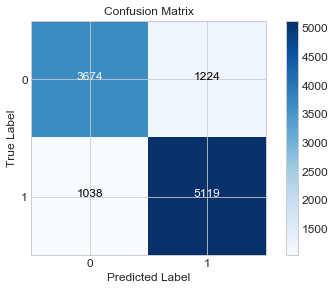

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.03
No. Iterations to Converge: 44
Log-likelihood Lower Bound: 155.70
F1 Score:  0.74
Precision: 0.74     Recall:    0.74
*****************************************************


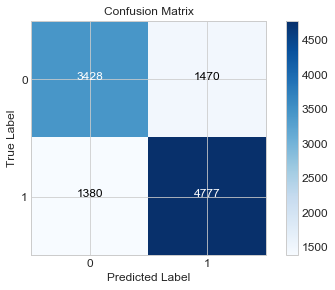

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.44
No. Iterations to Converge: 20
Log-likelihood Lower Bound: 110.95
F1 Score:  0.76
Precision: 0.77     Recall:    0.76
*****************************************************


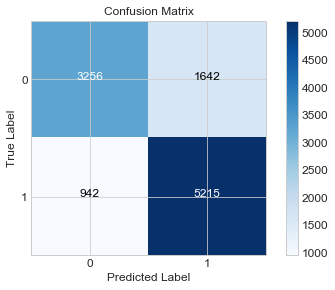

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.34
No. Iterations to Converge: 8
Log-likelihood Lower Bound: 39.43
F1 Score:  0.91
Precision: 0.92     Recall:    0.91
*****************************************************


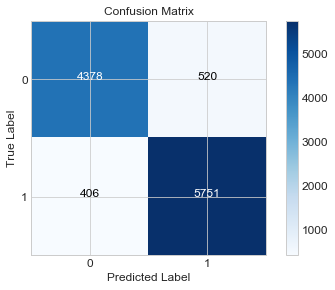

In [195]:
evaluate_EM(EM(n_components=18,covariance_type='diag',n_init=1,warm_start=True,random_state=100),pca_phish,phishY)
evaluate_EM(EM(n_components=28,covariance_type='diag',n_init=1,warm_start=True,random_state=100),ica_phish,phishY)
evaluate_EM(EM(n_components=25,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rca_phish,phishY)
evaluate_EM(EM(n_components=22,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rfc_phish,phishY)

#Star

In [36]:
pca_bank = PCA(n_components=2,random_state=5).fit_transform(bankX)
ica_bank = ICA(n_components=5,random_state=5).fit_transform(bankX)
rca_bank = ICA(n_components=5,random_state=5).fit_transform(bankX)
rfc_bank = df_star[topcols_bank]
rfc_bank = np.array(rfc_bank.values,dtype='int64')

In [ ]:
# y_train.shape
# rca_bank.shape
# df_star.shape
df_star

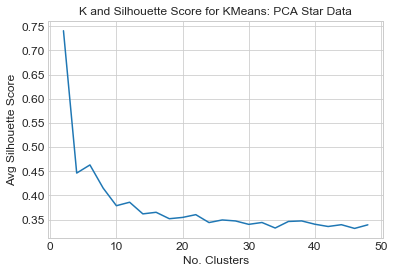

<Figure size 432x288 with 0 Axes>

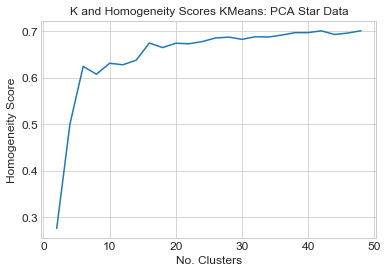

<Figure size 432x288 with 0 Axes>

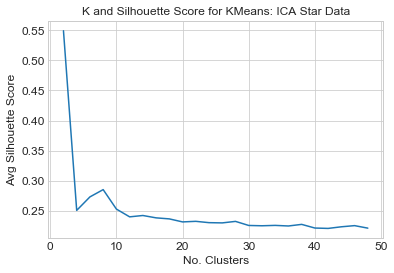

<Figure size 432x288 with 0 Axes>

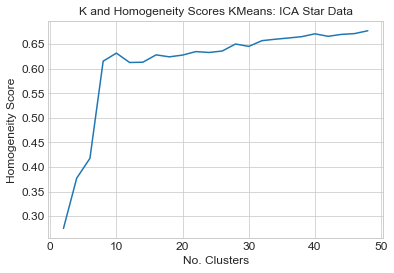

<Figure size 432x288 with 0 Axes>

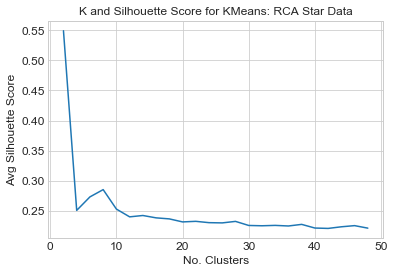

<Figure size 432x288 with 0 Axes>

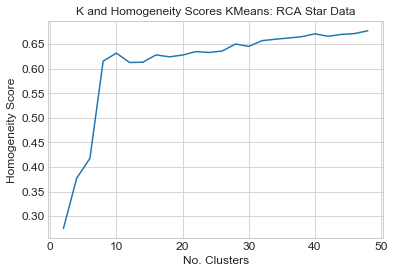

<Figure size 432x288 with 0 Axes>

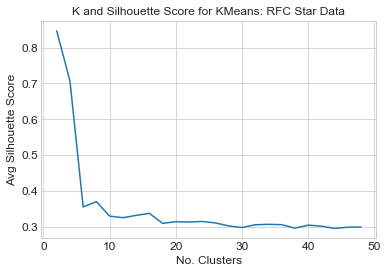

<Figure size 432x288 with 0 Axes>

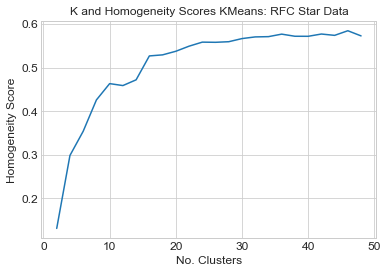

<Figure size 432x288 with 0 Axes>

In [39]:
run_kmeans(pca_bank,bankY,'PCA Star Data')
run_kmeans(ica_bank,bankY,'ICA Star Data')
run_kmeans(rca_bank,bankY,'RCA Star Data')
run_kmeans(rfc_bank,bankY,'RFC Star Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.07
No. Iterations to Converge: 7
F1 Score:  0.76
Precision: 0.75     Recall:    0.78
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.39
No. Iterations to Converge: 23
F1 Score:  0.73
Precision: 0.97     Recall:    0.66
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.41
No. Iterations to Converge: 23
F1 Score:  0.73
Precision: 0.97     Recall:    0.66
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.28
No. Iterations to Converge: 21
F1 Score:  0.75
Pre

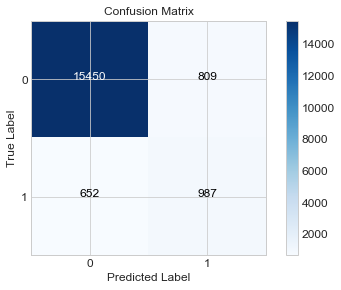

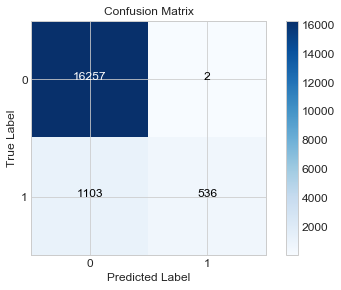

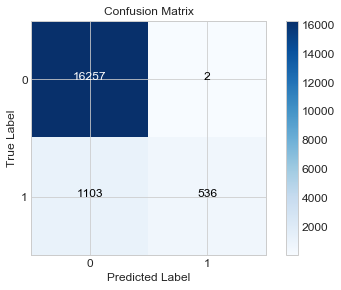

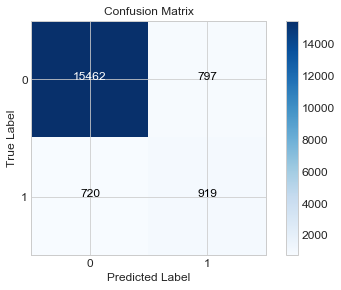

In [40]:
evaluate_kmeans(KMeans(n_clusters=2,n_init=10,random_state=100,n_jobs=-1),pca_bank,bankY)
evaluate_kmeans(KMeans(n_clusters=5,n_init=10,random_state=100,n_jobs=-1),ica_bank,bankY)
evaluate_kmeans(KMeans(n_clusters=5,n_init=10,random_state=100,n_jobs=-1),rca_bank,bankY)
evaluate_kmeans(KMeans(n_clusters=5,n_init=10,random_state=100,n_jobs=-1),rfc_bank,bankY)


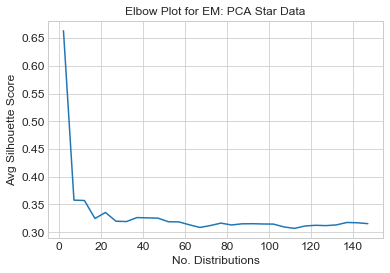

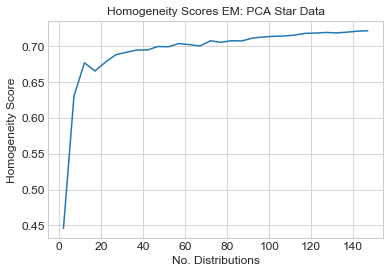

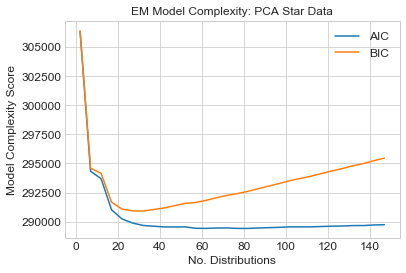

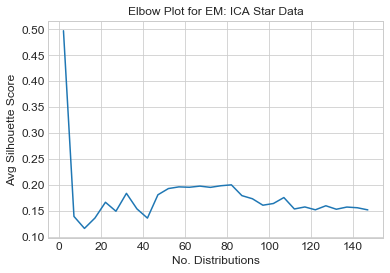

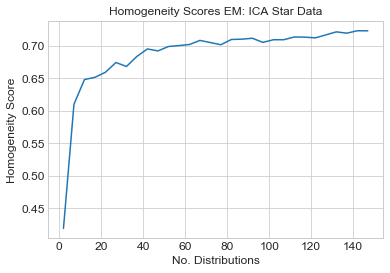

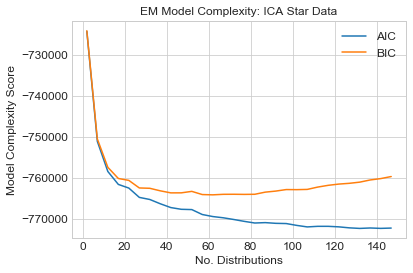

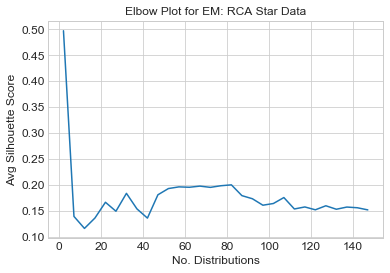

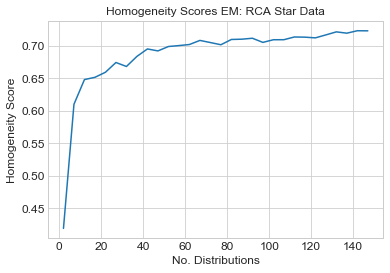

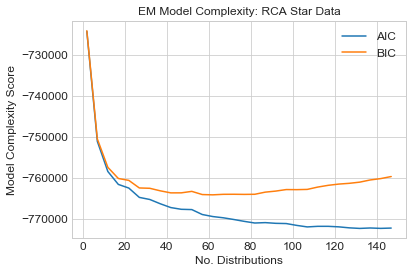

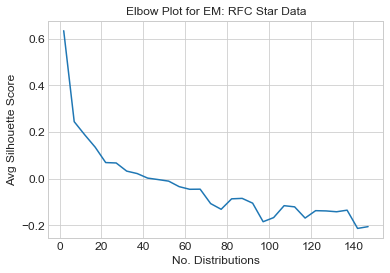

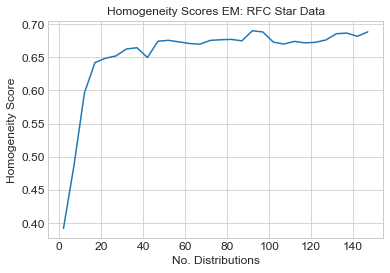

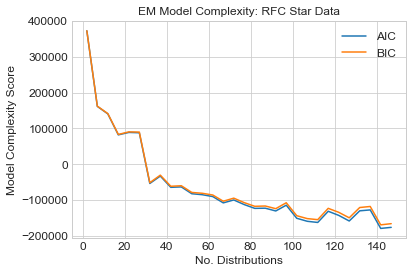

In [41]:
run_EM(pca_bank,bankY,'PCA Star Data')
run_EM(ica_bank,bankY,'ICA Star Data')
run_EM(rca_bank,bankY,'RCA Star Data')
run_EM(rfc_bank,bankY,'RFC Star Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.05
No. Iterations to Converge: 7
Log-likelihood Lower Bound: -8.56
F1 Score:  0.79
Precision: 0.75     Recall:    0.90
*****************************************************


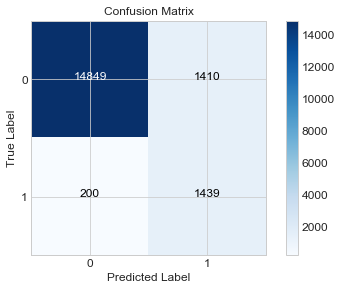

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.16
No. Iterations to Converge: 20
Log-likelihood Lower Bound: 20.88
F1 Score:  0.88
Precision: 0.97     Recall:    0.82
*****************************************************


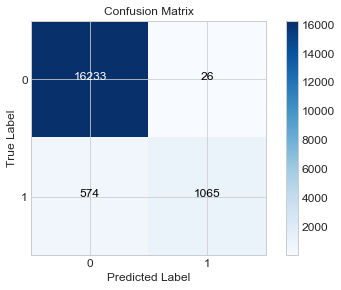

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.16
No. Iterations to Converge: 20
Log-likelihood Lower Bound: 20.88
F1 Score:  0.88
Precision: 0.97     Recall:    0.82
*****************************************************


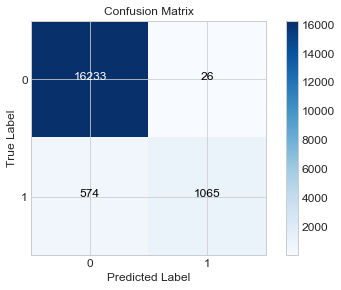

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.11
No. Iterations to Converge: 8
Log-likelihood Lower Bound: -5.29
F1 Score:  0.75
Precision: 0.74     Recall:    0.75
*****************************************************


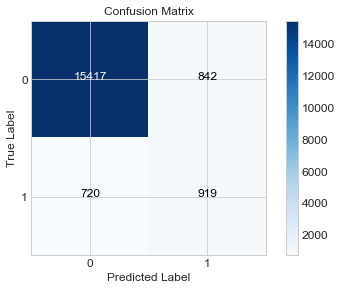

In [42]:
evaluate_EM(EM(n_components=2,covariance_type='diag',n_init=1,warm_start=True,random_state=100),pca_bank,bankY)
evaluate_EM(EM(n_components=5,covariance_type='diag',n_init=1,warm_start=True,random_state=100),ica_bank,bankY)
evaluate_EM(EM(n_components=5,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rca_bank,bankY)
evaluate_EM(EM(n_components=5,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rfc_bank,bankY)


# NN

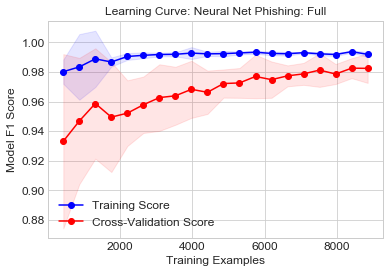

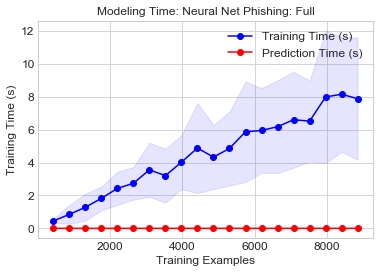

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.78394
Model Prediction Time (s): 0.00356

F1 Score:  0.98
Precision: 0.99     Recall:    0.97
*****************************************************


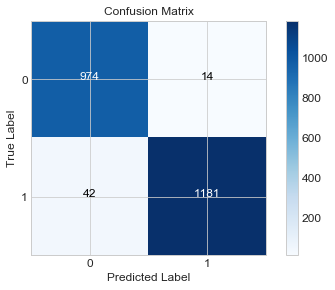

<Figure size 432x288 with 0 Axes>

In [205]:
X_train, X_test, y_train, y_test = train_test_split(np.array(phishX),np.array(phishY), test_size=0.20)
full_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_full, NN_train_score_full, NN_fit_time_full, NN_pred_time_full = plot_learning_curve(full_est, X_train, y_train,title="Neural Net Phishing: Full")
final_classifier_evaluation(full_est, X_train, X_test, y_train, y_test)


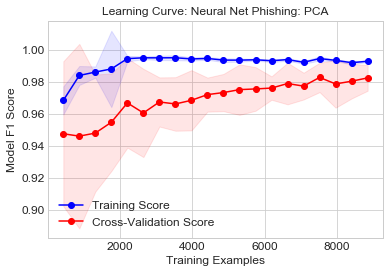

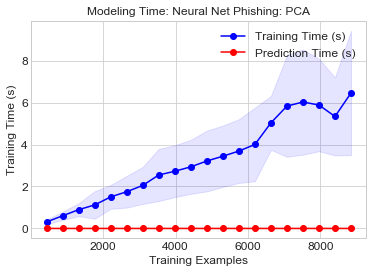

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.09292
Model Prediction Time (s): 0.00164

F1 Score:  0.97
Precision: 0.96     Recall:    0.98
*****************************************************


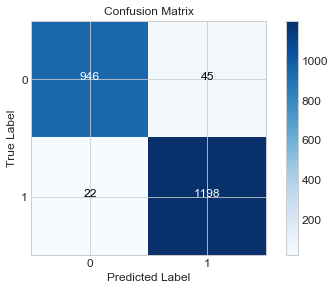

<Figure size 432x288 with 0 Axes>

In [206]:
X_train, X_test, y_train, y_test = train_test_split(np.array(pca_phish),np.array(phishY), test_size=0.20)
pca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_pca, NN_train_score_pca, NN_fit_time_pca, NN_pred_time_pca = plot_learning_curve(pca_est, X_train, y_train,title="Neural Net Phishing: PCA")
final_classifier_evaluation(pca_est, X_train, X_test, y_train, y_test)

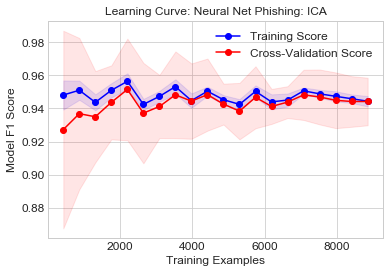

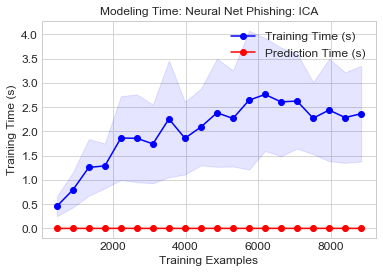

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   1.60320
Model Prediction Time (s): 0.00287

F1 Score:  0.95
Precision: 0.94     Recall:    0.96
*****************************************************


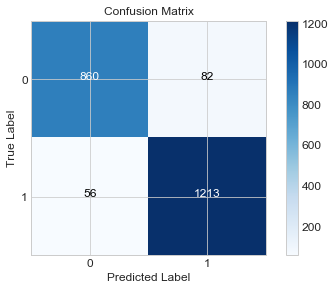

<Figure size 432x288 with 0 Axes>

In [207]:
X_train, X_test, y_train, y_test = train_test_split(np.array(ica_phish),np.array(phishY), test_size=0.20)
ica_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_ica, NN_train_score_ica, NN_fit_time_ica, NN_pred_time_ica = plot_learning_curve(ica_est, X_train, y_train,title="Neural Net Phishing: ICA")
final_classifier_evaluation(ica_est, X_train, X_test, y_train, y_test)

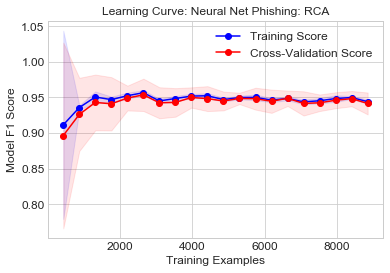

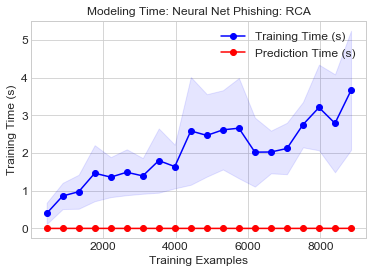

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   1.95521
Model Prediction Time (s): 0.00134

F1 Score:  0.94
Precision: 0.92     Recall:    0.96
*****************************************************


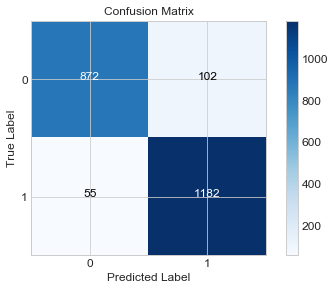

<Figure size 432x288 with 0 Axes>

In [208]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rca_phish),np.array(phishY), test_size=0.20)
rca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rca, NN_train_score_rca, NN_fit_time_rca, NN_pred_time_rca = plot_learning_curve(rca_est, X_train, y_train,title="Neural Net Phishing: RCA")
final_classifier_evaluation(rca_est, X_train, X_test, y_train, y_test)


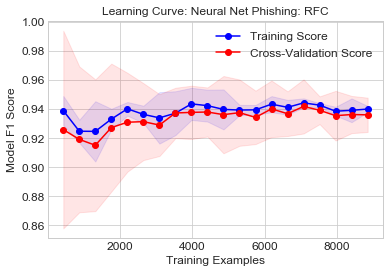

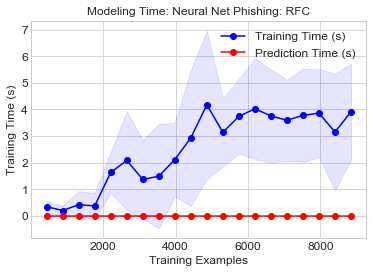

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   3.10421
Model Prediction Time (s): 0.00137

F1 Score:  0.94
Precision: 0.92     Recall:    0.97
*****************************************************


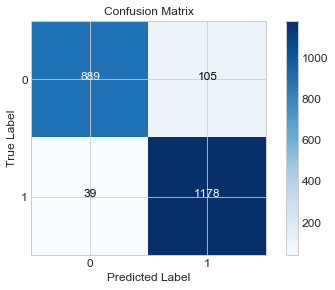

<Figure size 432x288 with 0 Axes>

In [209]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rfc_phish),np.array(phishY), test_size=0.20)
rfc_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rfc, NN_train_score_rfc, NN_fit_time_rfc, NN_pred_time_rfc = plot_learning_curve(rfc_est, X_train, y_train,title="Neural Net Phishing: RFC")
final_classifier_evaluation(rfc_est, X_train, X_test, y_train, y_test)


# Compare

In [210]:
def compare_fit_time(n,full_fit,pca_fit,ica_fit,rca_fit,rfc_fit,title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, full_fit, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_fit, '-', color="b", label="PCA")
    plt.plot(n, ica_fit, '-', color="r", label="ICA")
    plt.plot(n, rca_fit, '-', color="g", label="RCA")
    plt.plot(n, rfc_fit, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,full_pred, pca_pred, ica_pred, rca_pred, rfc_pred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, full_pred, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_pred, '-', color="b", label="PCA")
    plt.plot(n, ica_pred, '-', color="r", label="ICA")
    plt.plot(n, rca_pred, '-', color="g", label="RCA")
    plt.plot(n, rfc_pred, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show()


def compare_learn_time(n,full_learn, pca_learn, ica_learn, rca_learn, rfc_learn, title):
    
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(n, full_learn, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_learn, '-', color="b", label="PCA")
    plt.plot(n, ica_learn, '-', color="r", label="ICA")
    plt.plot(n, rca_learn, '-', color="g", label="RCA")
    plt.plot(n, rfc_learn, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show() 


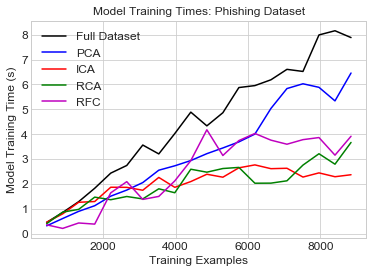

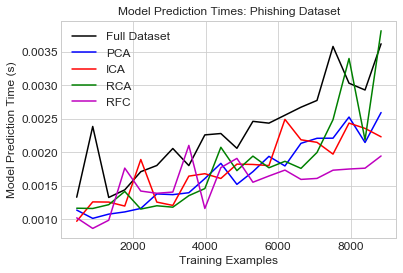

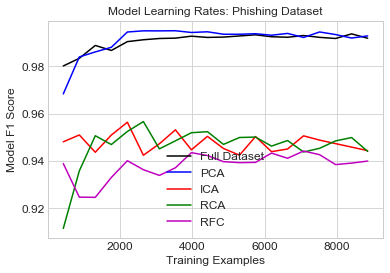

In [211]:
compare_fit_time(train_samp_full, NN_fit_time_full, NN_fit_time_pca, NN_fit_time_ica, 
                 NN_fit_time_rca, NN_fit_time_rfc, 'Phishing Dataset')              
compare_pred_time(train_samp_full, NN_pred_time_full, NN_pred_time_pca, NN_pred_time_ica, 
                 NN_pred_time_rca, NN_pred_time_rfc, 'Phishing Dataset')   
compare_learn_time(train_samp_full, NN_train_score_full, NN_train_score_pca, NN_train_score_ica, 
                 NN_train_score_rca, NN_train_score_rfc, 'Phishing Dataset')  


In [212]:
def addclusters(X,km_lables,em_lables):
    
    df = pd.DataFrame(X)
    df['KM Cluster'] = km_labels
    df['EM Cluster'] = em_labels
    col_1hot = ['KM Cluster', 'EM Cluster']
    df_1hot = df[col_1hot]
    df_1hot = pd.get_dummies(df_1hot).astype('category')
    df_others = df.drop(col_1hot,axis=1)
    df = pd.concat([df_others,df_1hot],axis=1)
    new_X = np.array(df.values,dtype='int64')   
    
    return new_X


In [213]:
km = KMeans(n_clusters=9,n_init=10,random_state=100,n_jobs=-1).fit(phishX)
km_labels = km.labels_
em = EM(n_components=24,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(phishX)
em_labels = em.predict(phishX)

clust_full = addclusters(phishX,km_labels,em_labels)
clust_pca = addclusters(pca_phish,km_labels,em_labels)
clust_ica = addclusters(ica_phish,km_labels,em_labels)
clust_rca = addclusters(rca_phish,km_labels,em_labels)
clust_rfc = addclusters(rfc_phish,km_labels,em_labels)


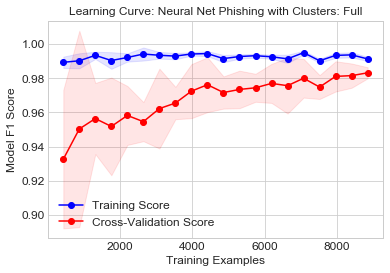

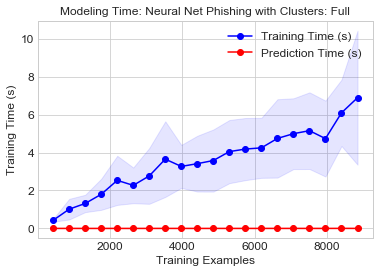

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   6.69333
Model Prediction Time (s): 0.00515

F1 Score:  0.97
Precision: 0.97     Recall:    0.97
*****************************************************


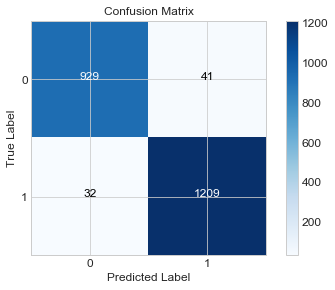

<Figure size 432x288 with 0 Axes>

In [214]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_full),np.array(phishY), test_size=0.20)
full_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_full, NN_train_score_full, NN_fit_time_full, NN_pred_time_full = plot_learning_curve(full_est, X_train, y_train,title="Neural Net Phishing with Clusters: Full")
final_classifier_evaluation(full_est, X_train, X_test, y_train, y_test)

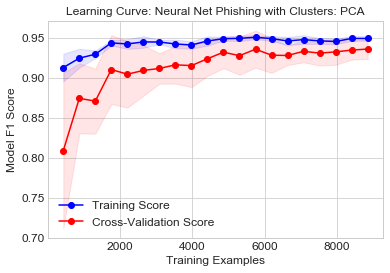

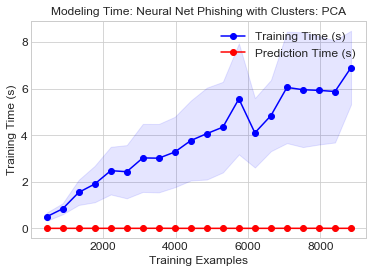

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.15044
Model Prediction Time (s): 0.00186

F1 Score:  0.93
Precision: 0.91     Recall:    0.95
*****************************************************


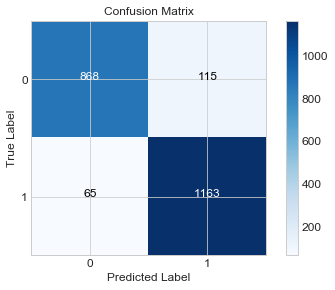

<Figure size 432x288 with 0 Axes>

In [215]:

X_train, X_test, y_train, y_test = train_test_split(np.array(clust_pca),np.array(phishY), test_size=0.20)
pca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_pca, NN_train_score_pca, NN_fit_time_pca, NN_pred_time_pca = plot_learning_curve(pca_est, X_train, y_train,title="Neural Net Phishing with Clusters: PCA")
final_classifier_evaluation(pca_est, X_train, X_test, y_train, y_test)

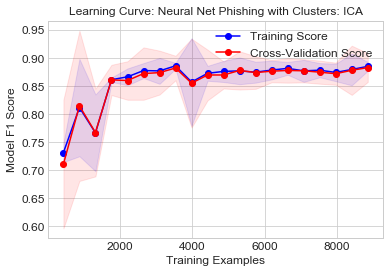

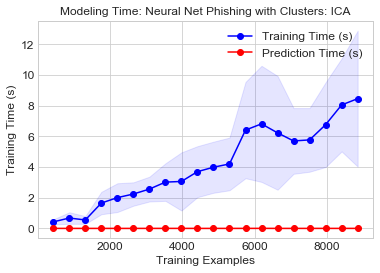

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.64521
Model Prediction Time (s): 0.00337

F1 Score:  0.88
Precision: 0.86     Recall:    0.91
*****************************************************


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


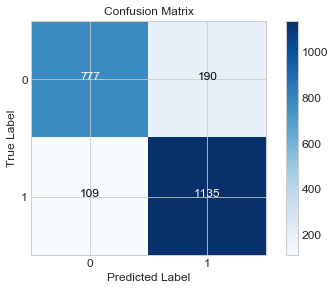

<Figure size 432x288 with 0 Axes>

In [216]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_ica),np.array(phishY), test_size=0.20)
ica_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_ica, NN_train_score_ica, NN_fit_time_ica, NN_pred_time_ica = plot_learning_curve(ica_est, X_train, y_train,title="Neural Net Phishing with Clusters: ICA")
final_classifier_evaluation(ica_est, X_train, X_test, y_train, y_test)


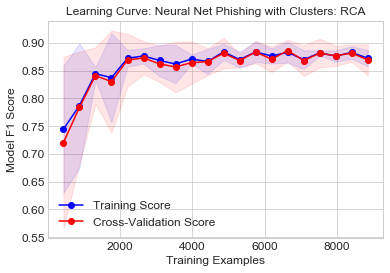

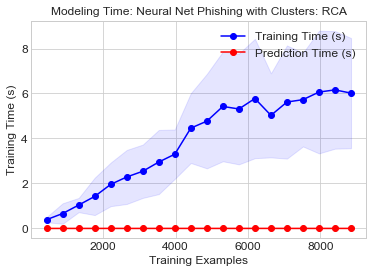

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.06664
Model Prediction Time (s): 0.00201

F1 Score:  0.89
Precision: 0.85     Recall:    0.94
*****************************************************


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


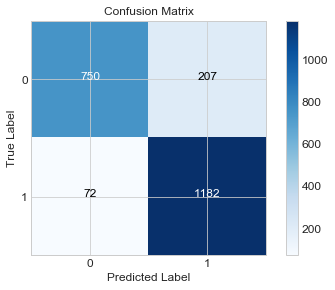

<Figure size 432x288 with 0 Axes>

In [217]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rca),np.array(phishY), test_size=0.20)
rca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rca, NN_train_score_rca, NN_fit_time_rca, NN_pred_time_rca = plot_learning_curve(rca_est, X_train, y_train,title="Neural Net Phishing with Clusters: RCA")
final_classifier_evaluation(rca_est, X_train, X_test, y_train, y_test)


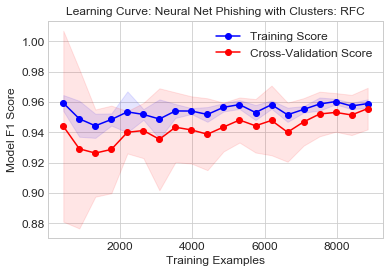

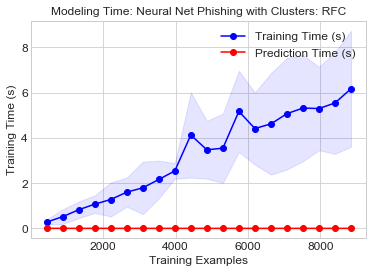

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.48003
Model Prediction Time (s): 0.00192

F1 Score:  0.95
Precision: 0.95     Recall:    0.94
*****************************************************


/Users/YCheng/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


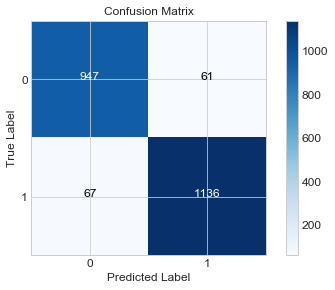

<Figure size 432x288 with 0 Axes>

In [218]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rfc),np.array(phishY), test_size=0.20)
rfc_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rfc, NN_train_score_rfc, NN_fit_time_rfc, NN_pred_time_rfc = plot_learning_curve(rfc_est, X_train, y_train,title="Neural Net Phishing with Clusters: RFC")
final_classifier_evaluation(rfc_est, X_train, X_test, y_train, y_test)

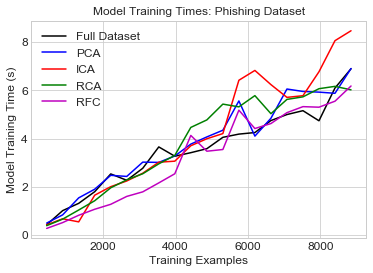

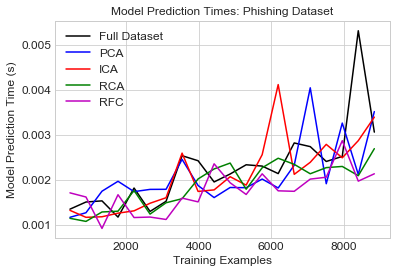

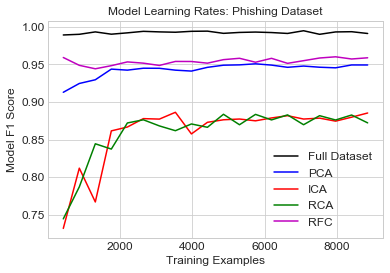

In [219]:
compare_fit_time(train_samp_full, NN_fit_time_full, NN_fit_time_pca, NN_fit_time_ica, 
                 NN_fit_time_rca, NN_fit_time_rfc, 'Phishing Dataset')              
compare_pred_time(train_samp_full, NN_pred_time_full, NN_pred_time_pca, NN_pred_time_ica, 
                 NN_pred_time_rca, NN_pred_time_rfc, 'Phishing Dataset')   
compare_learn_time(train_samp_full, NN_train_score_full, NN_train_score_pca, NN_train_score_ica, 
                 NN_train_score_rca, NN_train_score_rfc, 'Phishing Dataset')  

